# Time delay-cosmography simulations

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

plotting = True
if plotting:
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    %matplotlib inline

## simulation choices

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


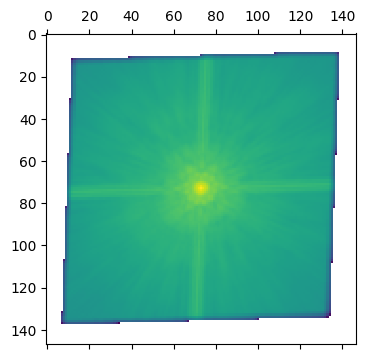

In [2]:
# import main simulation class of lenstronomy
from lenstronomy.SimulationAPI.simulations import Simulation
SimAPI = Simulation()

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

if plotting:
    plt.matshow(np.log10(kernel))
    plt.show()


    
    
# data specifics
sigma_bkg = .01  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'pixel'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data_single = SimAPI.data_configure(numPix, deltaPix, exp_time, sigma_bkg)
# generate the psf variables
kwargs_psf_single = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, truncate=3, kernel=kernel)



In [3]:
# lensing quantities
kwargs_shear = {'e1': 0.0, 'e2': -0.1}  # shear values to the source plane
kwargs_spemd = {'theta_E': 1.66, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'q': .8, 'phi_G': 0.}  # parameters of the deflector lens model

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0


# Sersic parameters in the initial simulation
kwargs_sersic_source = {'I0_sersic': 4, 'R_sersic': 0.05, 'n_sersic': 1, 'q': .8, 'phi_G': 0.5, 'center_x': source_x, 'center_y': source_y}
kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}


source_model_list = ['SERSIC_ELLIPSE']
kwargs_source_list = [kwargs_sersic_source]


# lens light model
kwargs_sersic_lens = {'I0_sersic': 20, 'R_sersic': 0.2, 'n_sersic': 2, 'q': .9, 'phi_G': 0.9, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light_list = [kwargs_sersic_lens]



# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SPEMD', 'SHEAR']
kwargs_lens_list = [kwargs_spemd, kwargs_shear]

kwargs_options = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 'foreground_shear': False,  # we don't explicitly model the non-linear shear components
                  'subgrid_res': 2,  # numerical precision in the ray-tracing. Possibility of sub-pixel precision exists
                  'psf_subgrid': True,  # subgrid convolution kernel
                  'point_source': True,  # modelling point sources
                  'solver': True,  # solves the 4-image point source configuration with a non-linear solver
                  #'num_images': 4
                 }

# generate image
image_real_lensed_shear = SimAPI.im_sim(kwargs_options, kwargs_data_single, kwargs_psf_single, kwargs_lens_list, kwargs_source_list, kwargs_lens_light_list, kwargs_else)
# update kwargs_data with the newly generated mock
kwargs_data_single['image_data'] = image_real_lensed_shear

from lenstronomy.Analysis.lens_properties import LensProp
lensProp = LensProp(z_lens, z_source, kwargs_options, kwargs_data_single, cosmo=cosmo)

# time delays
dt_days = lensProp.time_delays(kwargs_lens_list, kwargs_else, kappa_ext=0)
print("the time delays for the images at position ", kwargs_else['ra_pos'], kwargs_else['dec_pos'], "are: ",dt_days)


# kinematics

R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7
num_evaluate = 1000  # numerical ray-shooting, should converge -> infinity
kwargs_aperture = {'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OsipkovMerritt'
aperture_type = 'slit'

r_ani = 1.
r_eff = 0.2
kwargs_anisotropy = {'r_ani': r_ani}

vel_disp = lensProp.velocity_disperson_new(kwargs_lens_list, kwargs_lens_light_list, kwargs_else, kwargs_anisotropy, kwargs_aperture, psf_fwhm, aperture_type, anisotropy_model, MGE_light=True, MGE_mass=True, r_eff=r_eff)
print(vel_disp, 'velocity dispersion in km/s')

('the time delays for the images at position ', array([-1.29583094,  0.99592927,  0.27669797,  1.4596848 ]), array([-0.34513872,  1.29702629,  1.66741547, -1.36284606]), 'are: ', array([ -86.01104926, -134.7112631 , -135.48467494, -165.3661448 ]))
(array([ 237.80481342]), 'velocity dispersion in km/s')


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


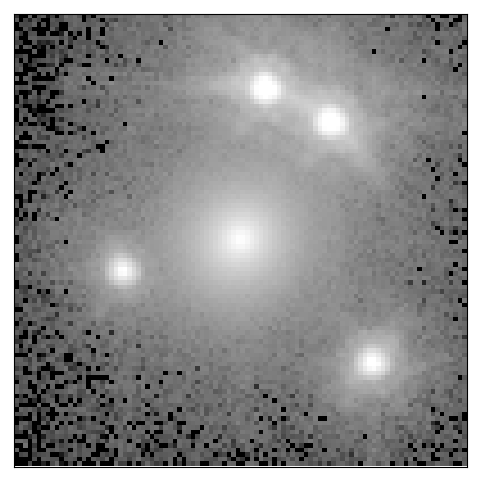

In [4]:
# display the initial simulated image
if plotting:
    cmap_string = 'gray'
    cmap = plt.get_cmap(cmap_string)
    cmap.set_bad(color='k', alpha=1.)
    cmap.set_under('k')

    v_min = -4
    v_max = 2

    f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

    # sequence of weak lensing
    ax = axes
    im = ax.matshow(np.log10(image_real_lensed_shear), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)

    plt.show()

## Model and parameter choices

In [5]:
# lens model choicers
lens_model_list = []
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

lens_model_list.append('SPEMD')
fixed_lens.append({}) 
#kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'q': 1., 'phi_G': 0.})
kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E_sigma': .1, 'ellipse_sigma':0.1, 'gamma_sigma': 0.2, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

lens_model_list.append('SHEAR')
fixed_lens.append({})
#kwargs_lens_init.append({'e1': 0.0, 'e2': 0.0})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'shear_sigma': 0.1})
kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})


# lens light model choices
lens_light_model_list = []
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

lens_light_model_list.append('SERSIC_ELLIPSE')
fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.2, 'ellipse_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens_light.append({'q': .5, 'phi_G': 0, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'q': .5, 'phi_G': 0, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})


source_model_list = []
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

source_model_list.append('SERSIC_ELLIPSE')
fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.1, 'ellipse_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_source.append({'q': .5, 'phi_G': 0, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'q': .5, 'phi_G': 0, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})


fixed_else = {}
kwargs_else_init = kwargs_else
kwargs_else_sigma = {'shear_foreground_sigma': 0.01, 'pos_sigma': 0.01}
kwargs_lower_else = {'ra_pos': -10 * np.ones(len(kwargs_else['ra_pos'])), 'dec_pos': -10 * np.ones(len(kwargs_else['ra_pos'])), 'gamma1_foreground': -0.2, 'gamma2_foreground': -0.2}
kwargs_upper_else = {'ra_pos': 10* np.ones(len(kwargs_else['ra_pos'])), 'dec_pos': 10 * np.ones(len(kwargs_else['ra_pos'])), 'gamma1_foreground': 0.2, 'gamma2_foreground': 0.2}

kwargs_fixed = [fixed_lens, fixed_source, fixed_lens_light, fixed_else]
kwargs_init = [kwargs_lens_init, kwargs_source_init, kwargs_lens_light_init, kwargs_else_init]
kwargs_sigma = [kwargs_lens_sigma, kwargs_source_sigma, kwargs_lens_light_sigma, kwargs_else_sigma]
kwargs_lower = [kwargs_lower_lens, kwargs_lower_source, kwargs_lower_lens_light, kwargs_lower_else]
kwargs_upper = [kwargs_upper_lens, kwargs_upper_source, kwargs_upper_lens_light, kwargs_upper_else]



In [6]:
# numerical options and fitting sequences

kwargs_options = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 'foreground_shear': False,  # we don't explicitly model the non-linear shear components
                  'subgrid_res': 2,  # numerical precision in the ray-tracing. Possibility of sub-pixel precision exists
                  'psf_subgrid': True,  # subgrid convolution kernel
                  'point_source': True,  # modelling point sources
                  'solver': True,  # solves the 4-image point source configuration with a non-linear solver
                  'num_images': 4
                 }

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

fitting_kwargs_list = [
        #{'fitting_routine': 'lens_only', 'mpi': mpi, 'sigma_scale': 1, 'n_particles': n_p, 'n_iterations': n_i},
        #{'fitting_routine': 'lens_fixed', 'mpi': mpi, 'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i},
        #{'fitting_routine': 'lens_light_only', 'mpi': mpi, 'sigma_scale': .1, 'n_particles': n_p, 'n_iterations': n_i},
        #{'fitting_routine': 'source_only', 'mpi': mpi, 'sigma_scale': .1, 'n_particles': n_p, 'n_iterations': n_i},
        #{'fitting_routine': 'lens_combined_gamma_fixed', 'mpi': mpi, 'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i},
        #{'fitting_routine': 'psf_iteration', 'psf_iter_num': psf_iter_num, 'psf_iter_factor': psf_iter_factor}, 

        {'fitting_routine': 'lens_combined', 'mpi': mpi, 'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100},   
        {'fitting_routine': 'MCMC', 'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'mpi': mpi, 'sigma_scale': 1.}
        ]


kwargs_data = [kwargs_data_single]
kwargs_psf = [kwargs_psf_single]
init_samples = None

start_time = time.time()
fitting_seq = FittingSequence(kwargs_data, kwargs_psf, kwargs_options, kwargs_init, kwargs_sigma, kwargs_fixed, kwargs_lower, kwargs_upper)
lens_result, source_result, lens_light_result, else_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_psf_out = fitting_seq.kwargs_psf
output_ = [lens_result, source_result, lens_light_result, else_result, kwargs_psf_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc]
input_ = [kwargs_data, kwargs_psf, kwargs_options, kwargs_init, kwargs_sigma, kwargs_fixed, kwargs_lower, kwargs_upper, fitting_kwargs_list, init_samples]

end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the combined ...


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/numpy/linalg/linalg.py:1487: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
(-1.0115960002100517, 'reduced X^2 of best position')
(9978, 'effective number of data points')
([{'theta_E': 1.6598420106935303, 'q': 0.8009131538365859, 'center_x': 0.00089352624338210577, 'center_y': 0.00016753493234993166, 'phi_G': -0.0075226904433390064, 'gamma': 1.9996780257440134}, {'e1': -4.0009725546460656e-05, 'e2': -0.10058945142509636}], 'lens result')
([{'q': 0.79750137476728267, 'I0_sersic': 1, 'n_sersic': 0.9974690426637568, 'center_x': 0.19993896978379616, 'center_y': 0.00038164542298256554, 'phi_G': 0.47961183143043457, 'R_sersic': 0.050346916497175487}], 'source result')
([{'q': 0.8960479262380957, 'I0_sersic': 1, 'n_sersic': 2.0543300698369644, 'center_x': -8.2051929965816706e-05, 'center_y': -8.9202582204051737e-05, 'phi_G': 0.88529580747835213, 'R_sersic': 0.20176628735522928}], 'lens light result')
({'point_amp': array([ 1.,  1.,  1.,  1.]), 'ra_pos': array([-1.29599526,  0.99594699,  0.27675609,  1.459

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState
(1449.5051288604736, 'time taken for MCMC sampling')
(2044.7742838859558, 'total time needed for computation')
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


## analyse model output

('reduced chi^^ = ', 1.4759824635502352)


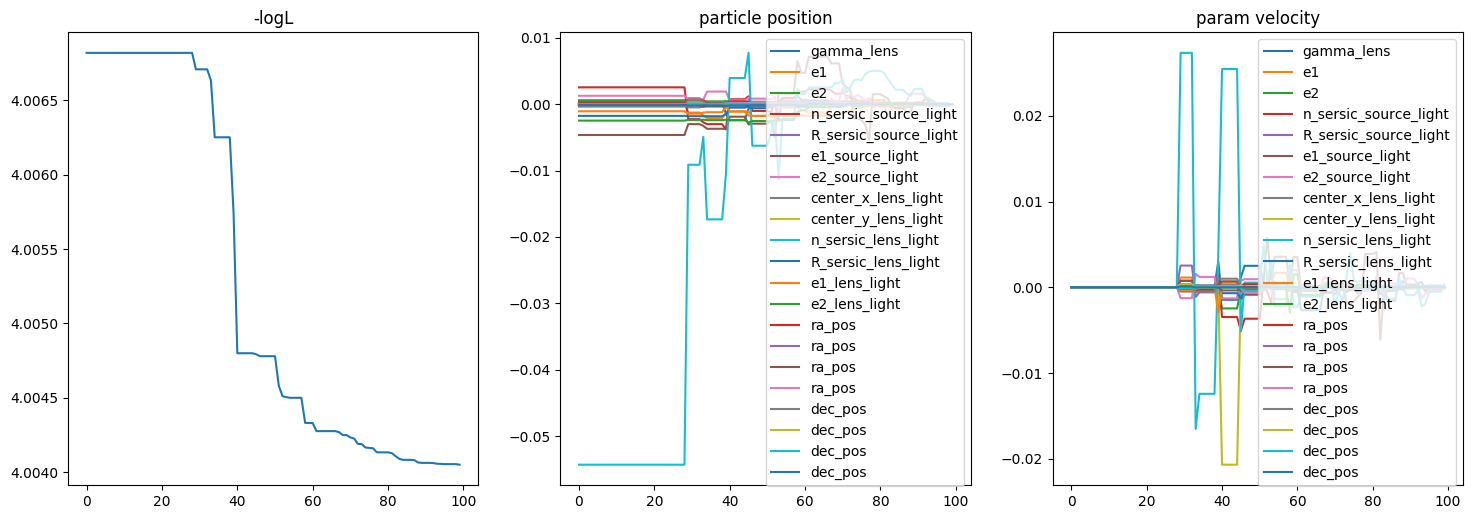

/Users/sibirrer/Cosmology/Software/lenstronomy_extensions/lenstronomy_extensions/Plots/output_plots.py:163: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


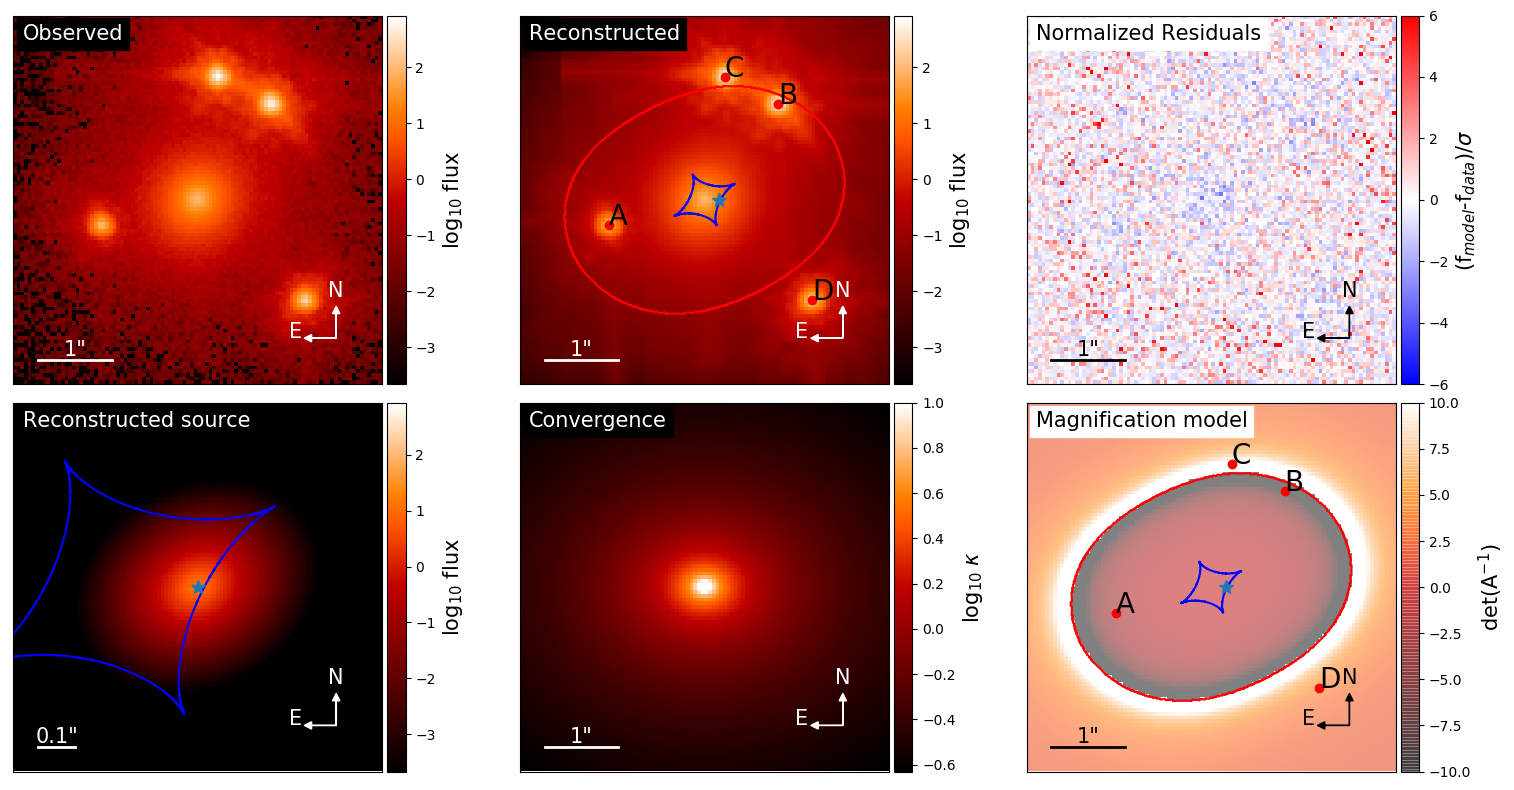

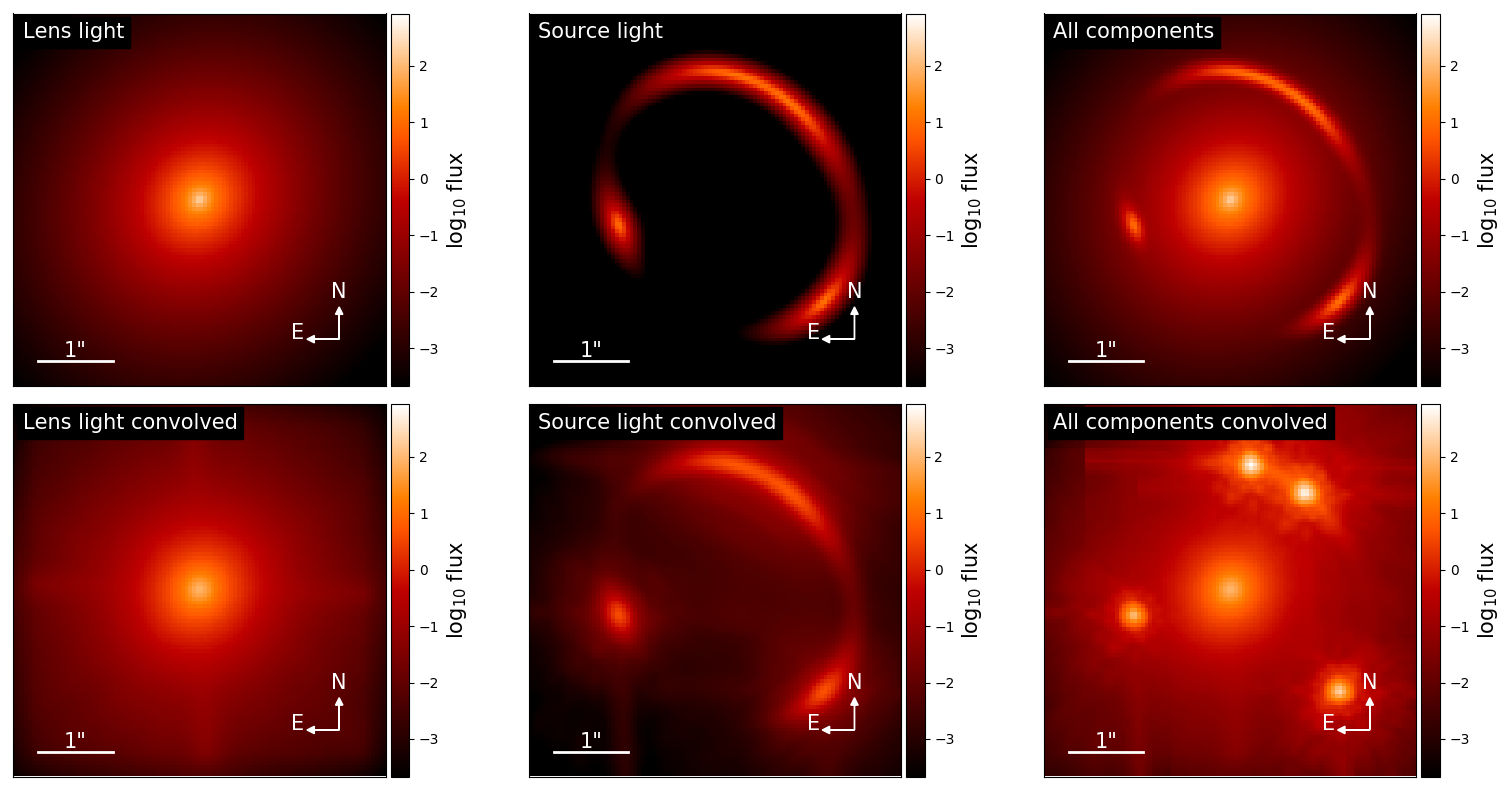

[{'theta_E': 1.6598420106935303, 'q': 0.8009131538365859, 'center_x': 0.00089352624338210577, 'center_y': 0.00016753493234993166, 'phi_G': -0.0075226904433390064, 'gamma': 1.9996780257440134}, {'e1': -4.0009725546460656e-05, 'e2': -0.10058945142509636}] [{'q': 0.79750137476728267, 'I0_sersic': 3.7658256685281035, 'n_sersic': 0.9974690426637568, 'center_x': 0.19993896978379616, 'center_y': 0.00038164542298256554, 'phi_G': 0.47961183143043457, 'R_sersic': 0.050346916497175487}] [{'q': 0.8960479262380957, 'I0_sersic': 19.383418611316827, 'n_sersic': 2.0543300698369644, 'center_x': -8.2051929965816706e-05, 'center_y': -8.9202582204051737e-05, 'phi_G': 0.88529580747835213, 'R_sersic': 0.20176628735522928}]


/Users/sibirrer/Cosmology/Software/lenstronomy_extensions/lenstronomy_extensions/Plots/output_plots.py:439: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


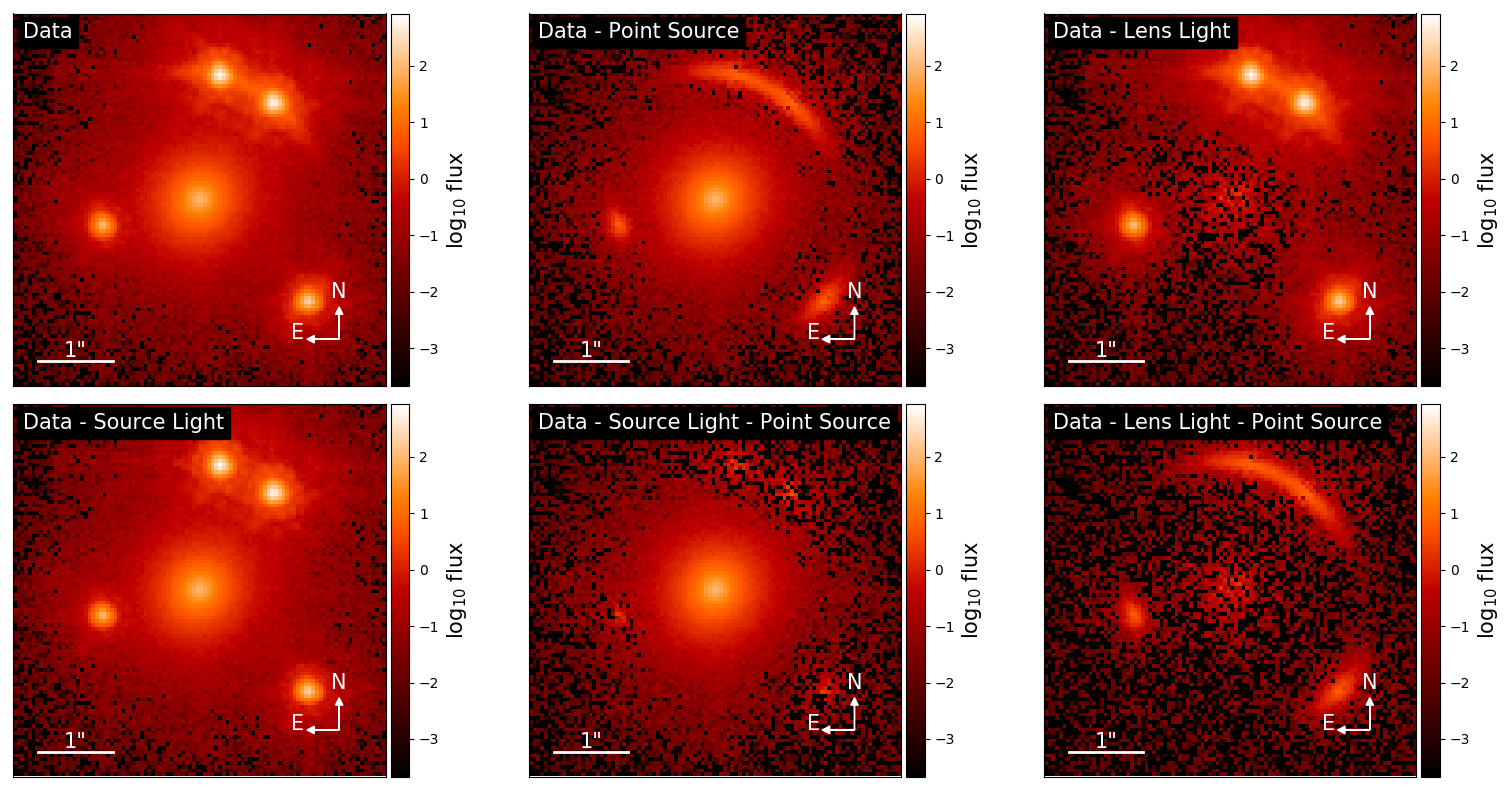

In [7]:
import lenstronomy_extensions.Plots.output_plots as out_plot

kwargs_data, kwargs_psf, kwargs_options, kwargs_init, kwargs_sigma, kwargs_fixed, kwargs_lower, kwargs_upper, fitting_kwargs_list, init_samples = input_
lens_result, source_result, lens_light_result, else_result, kwargs_psf, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = output_


band_i = 0
from lenstronomy_extensions.Plots.output_plots import LensModelPlot
lensPlot = LensModelPlot(kwargs_options, kwargs_data[band_i], kwargs_psf[band_i], lens_result, source_result, lens_light_result,
                        else_result, arrow_size=0.02, cmap_string="gist_heat", high_res=5)
    
if plotting: 
    
    for i in range(len(chain_list)):
        if len(param_list[i]) > 0:
            f, axes = out_plot.plot_chain(chain_list[i], param_list[i])
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.data_plot(ax=axes[0,0])
    lensPlot.model_plot(ax=axes[0,1])
    lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
    lensPlot.source_plot(ax=axes[1, 0],convolution=False, deltaPix_source=0.01, numPix=100)
    lensPlot.convergence_plot(ax=axes[1, 1], v_max=1)
    lensPlot.magnification_plot(ax=axes[1, 2])
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
    lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
    lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
    lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
    lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
    lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    print lens_result, source_result, lens_light_result
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.subtract_from_data_plot(ax=axes[0,0], text='Data')
    lensPlot.subtract_from_data_plot(ax=axes[0,1], text='Data - Point Source', point_source_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[0,2], text='Data - Lens Light', lens_light_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[1,0], text='Data - Source Light', source_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[1,1], text='Data - Source Light - Point Source', source_add=True, point_source_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[1,2], text='Data - Lens Light - Point Source', lens_light_add=True, point_source_add=True)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()


number of non-linear parameters in the MCMC process:  15
parameters in order:  ['gamma_lens', 'e1', 'e2', 'n_sersic_source_light', 'R_sersic_source_light', 'e1_source_light', 'e2_source_light', 'ra_pos', 'ra_pos', 'ra_pos', 'ra_pos', 'dec_pos', 'dec_pos', 'dec_pos', 'dec_pos']
number of evaluations in the MCMC process:  15000


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


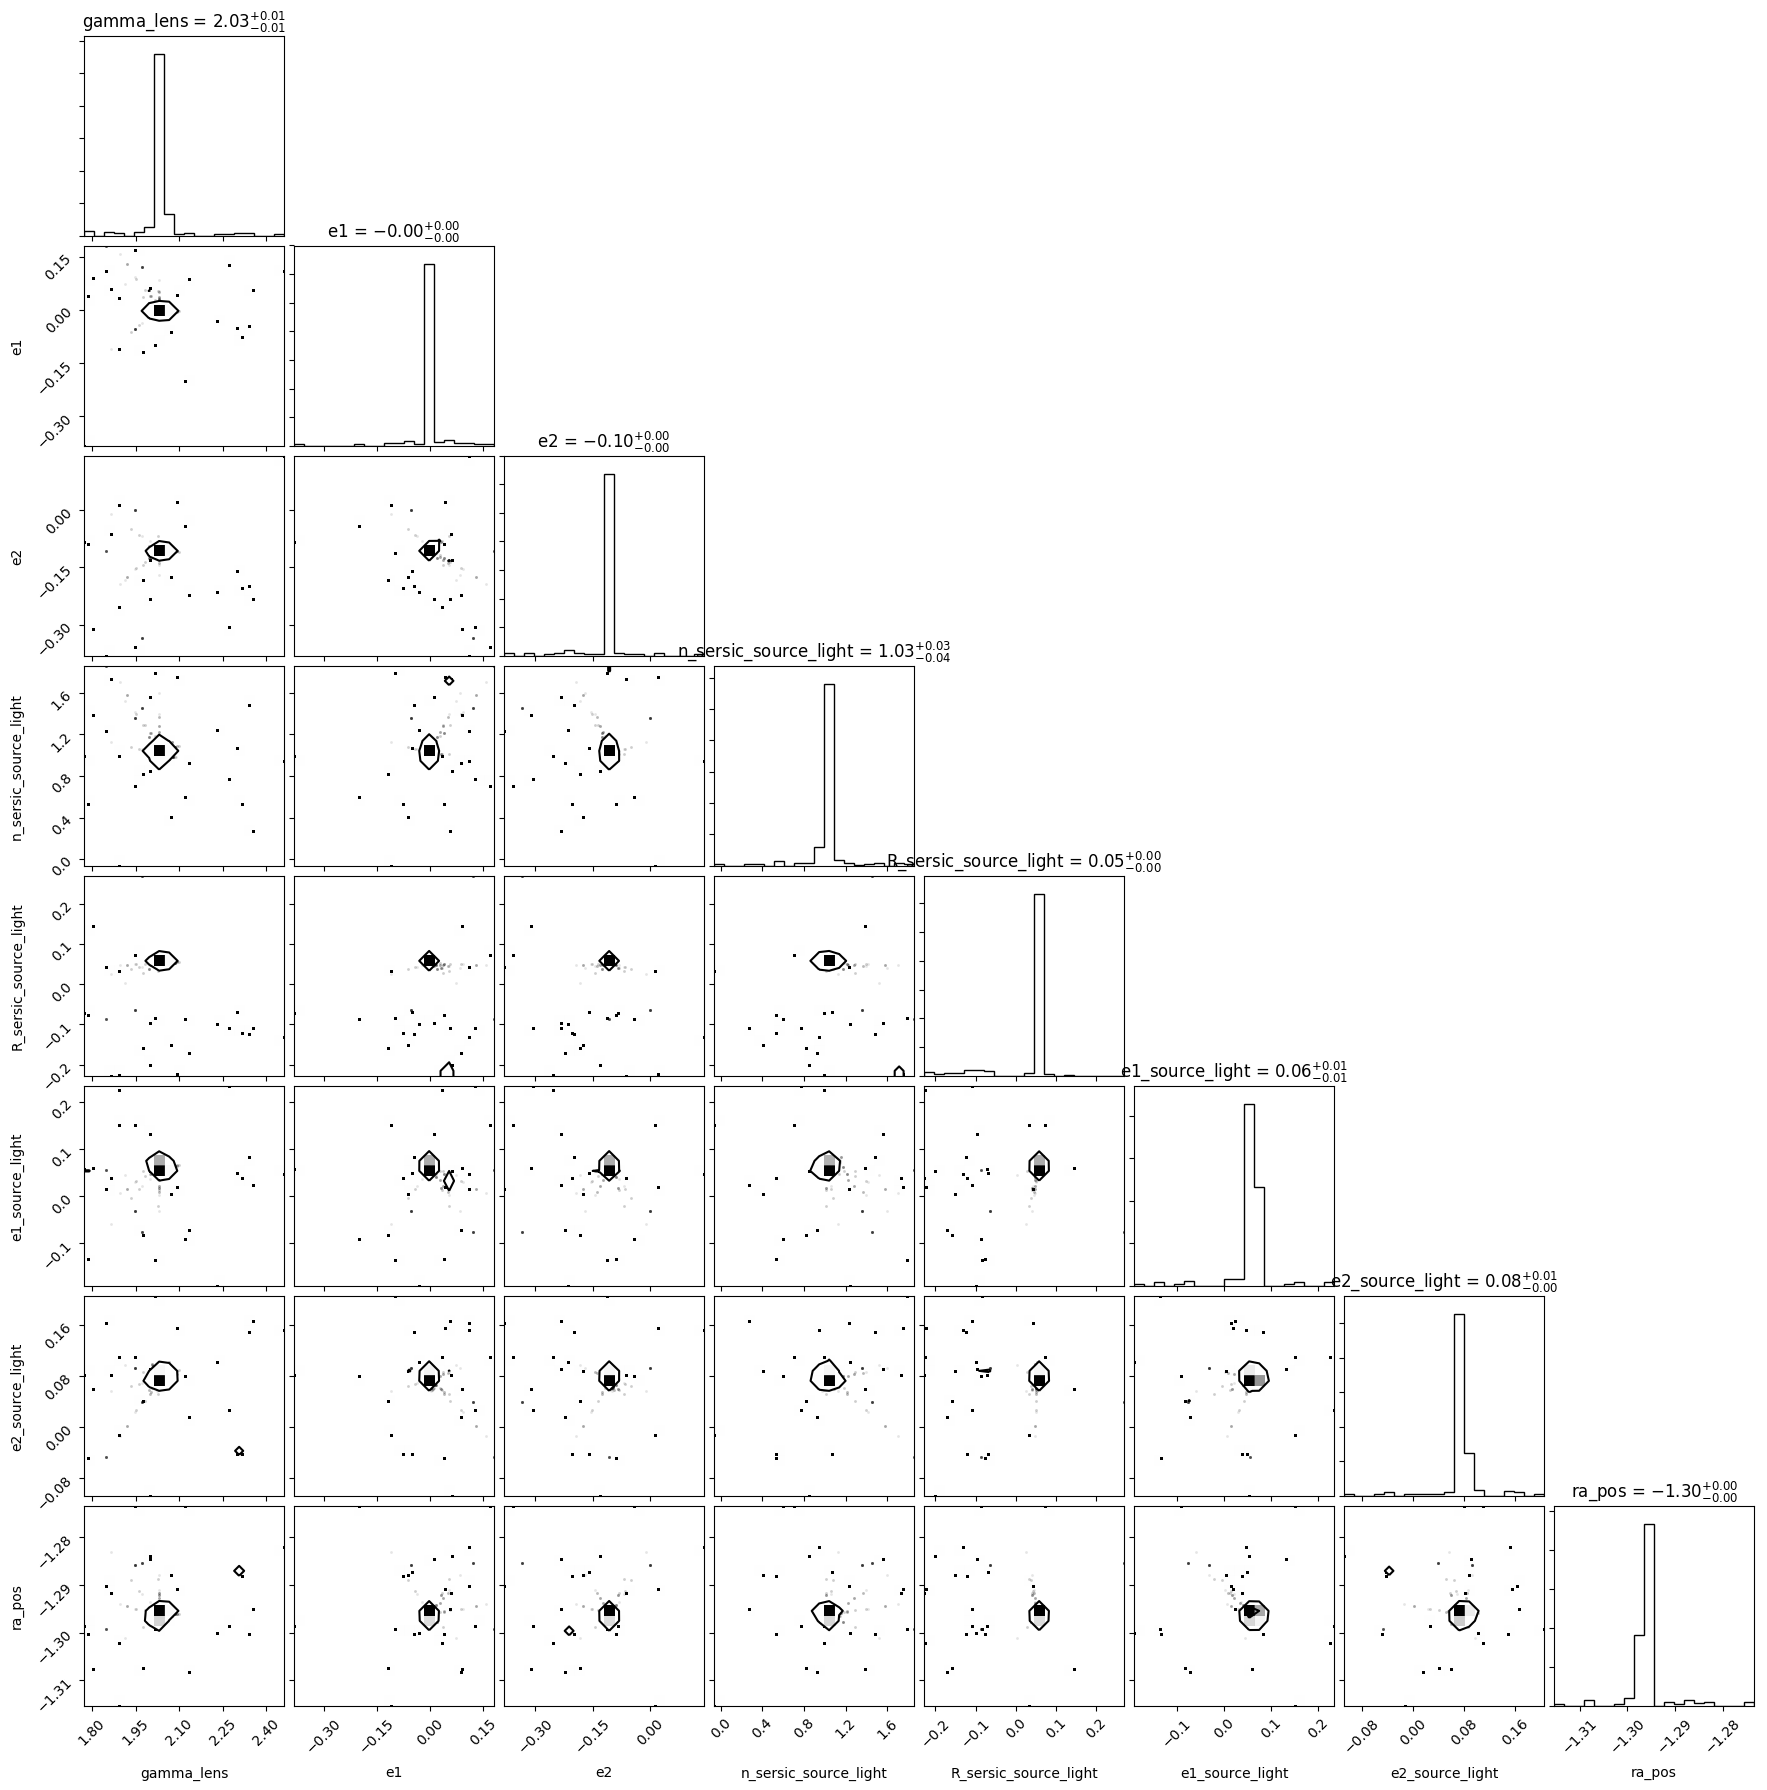

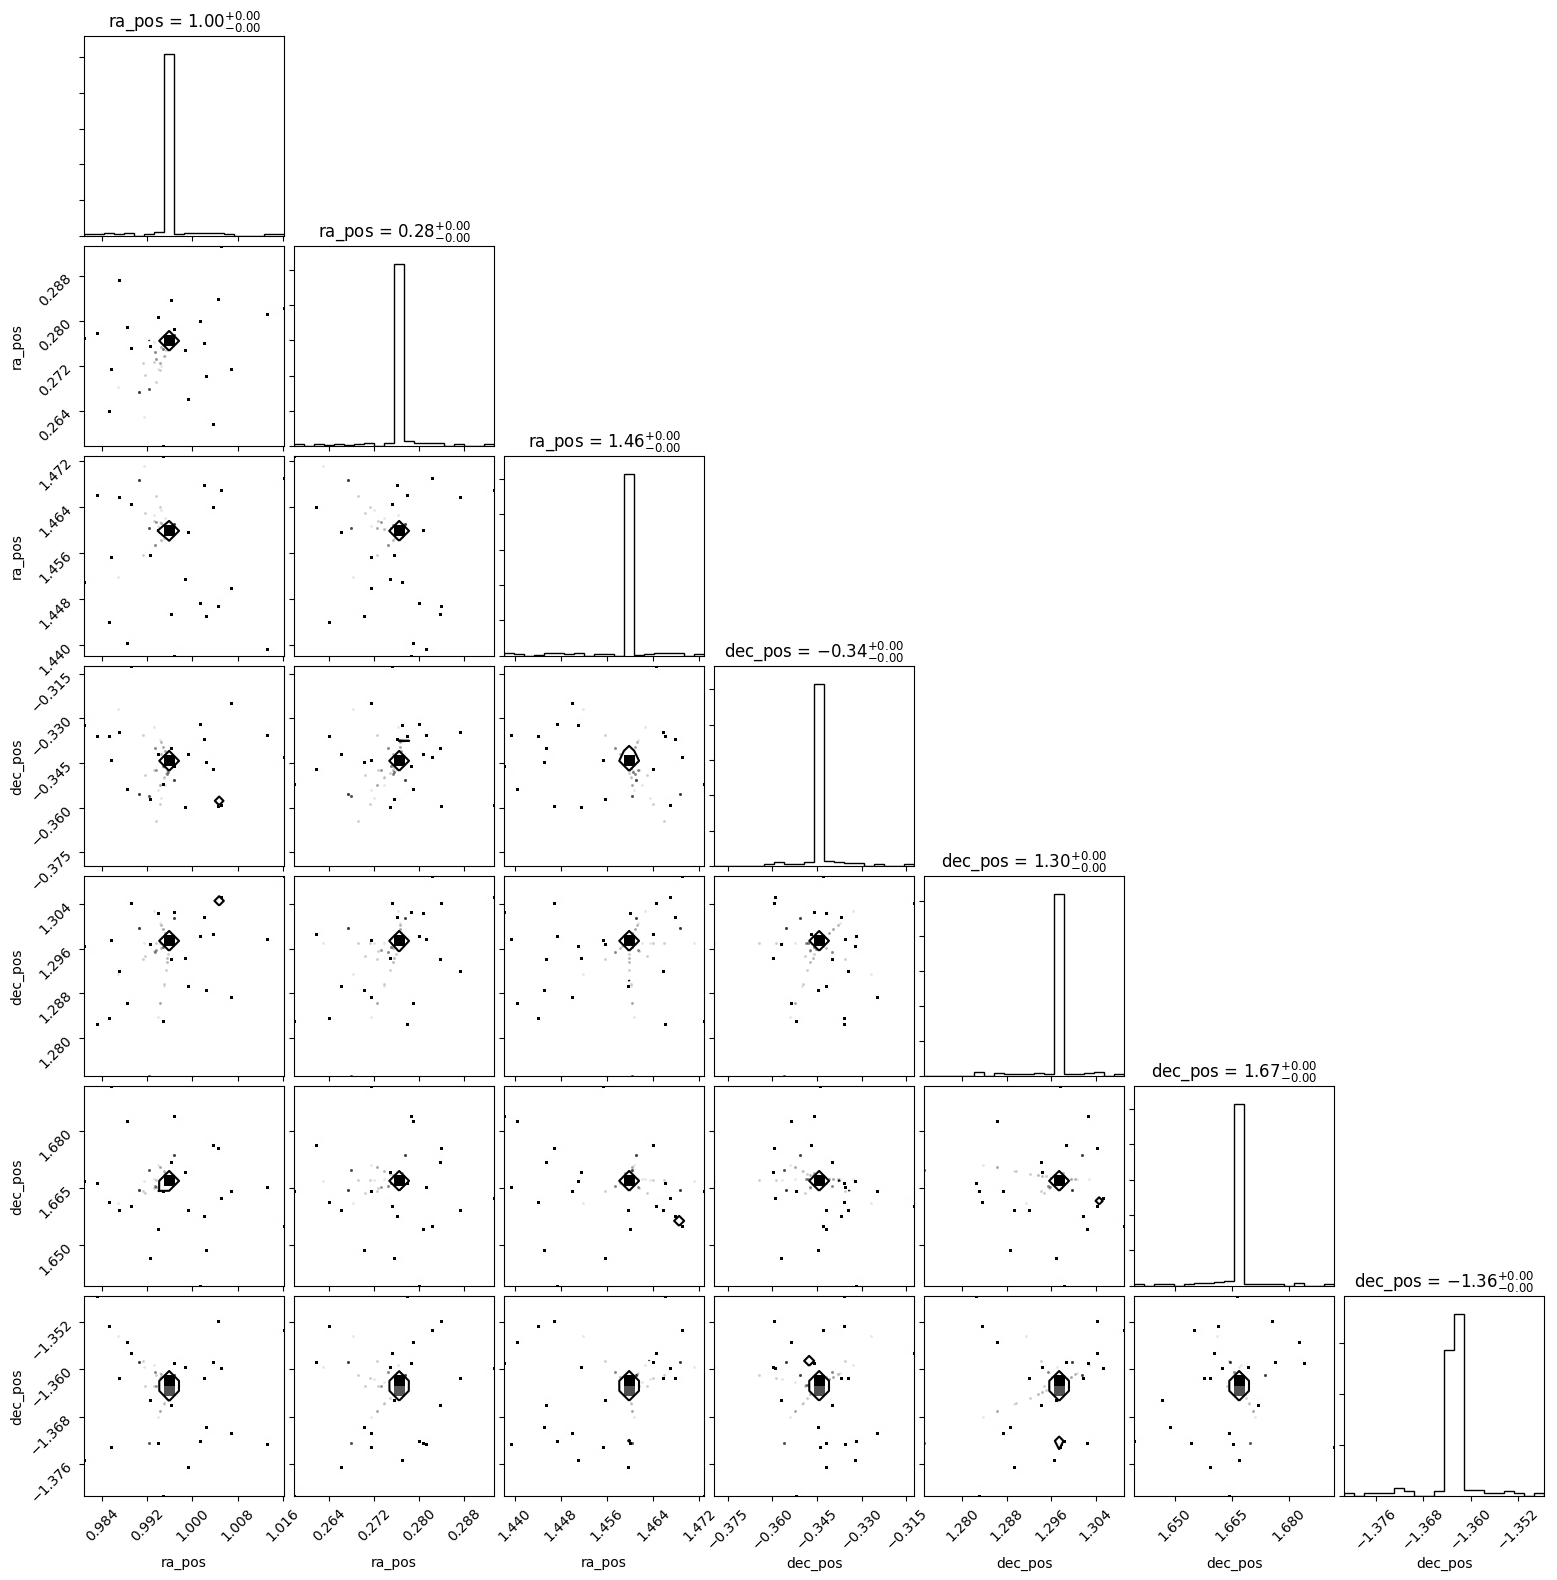

In [8]:
# the results of the MCMC chain, split in two corner plots

print "number of non-linear parameters in the MCMC process: ", len(param_mcmc)
print "parameters in order: ", param_mcmc
print "number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0]
if not samples_mcmc == []:
    if plotting:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
        plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)